* Usage of word over time


In [1]:
%run './model/multi_corpus.py'
%run './constants.py'

# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from collections import defaultdict
# from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, cosine_similarity

# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from nltk.tokenize import word_tokenize

In [57]:
import networkx as nx
import networkx.algorithms.community as nx_comm

from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

In [28]:
import pandas as pd

df_text = corpus.citation_df.select([pl.col('Doi'), pl.col('Text').str.split(' ')])

communities = fcluster(Z, 11, criterion='distance')
df_comm = pl.DataFrame({'Doi': leaves, 'Community': communities})

df_comm = (
    df_comm
        .join(df_text, left_on='Doi', right_on='Doi', how='left')
        .groupby('Community')
        .agg([
            pl.col('Doi'),
            pl.col('Text').flatten(),
        ])
        .with_column(pl.col('Text').arr.join(' '))
        .with_row_count()
)

dois = df_comm.get_column('Doi').to_list()
communities = df_comm.get_column('Community').to_list()
texts = df_comm.get_column('Text').to_list()

tv = TfidfVectorizer(min_df=0.,
                     max_df=1.,
                     norm='l2',
                     use_idf=True,
                     smooth_idf=True)

tv_matrix = tv.fit_transform(texts)

tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()

comm_term_tfidf = defaultdict(dict)
for (i, j) in list(zip(*np.where(tv_matrix != 0.0))):
    comm_term_tfidf[communities[i]][vocab[j]] = tv_matrix[i][j].round(3)

comm_term_tfidf = {k: dict(sorted(v.items(), key=lambda x: x[1], reverse=True)) for (k, v) in comm_term_tfidf.items()}

comm_ids = list(comm_term_tfidf.keys())

num_cols = len(comm_term_tfidf) * 2
num_rows = max(len(d) for d in comm_term_tfidf.values())

tab = np.zeros([num_rows, num_cols], dtype='<U21')

col = 0
for comm_id in comm_term_tfidf.keys():

    terms = list(comm_term_tfidf[comm_id].keys())
    terms = np.array(terms).reshape(len(terms),)

    tfidfs = list(comm_term_tfidf[comm_id].values())
    tfidfs = np.array(tfidfs).reshape(len(tfidfs),)

    tab[:len(terms), col] = terms
    tab[:len(tfidfs), col+1] = tfidfs

    col += 2

df = pd.DataFrame(tab)
df.columns = pd.MultiIndex.from_product([comm_ids, ['Term', 'Tfidf']])

df.head(25)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


7                             6                     9         \
              Term  Tfidf                   Term  Tfidf           Term  Tfidf   
0    institutional  0.365                    tie   0.29       resource  0.314   
1     organization  0.204               strength  0.251      sustained   0.31   
2             weak  0.203                 theory  0.215           firm  0.277   
3        knowledge  0.195             population  0.189    competitive  0.247   
4              tie  0.187                   weak  0.189      advantage  0.226   
5          inertia  0.162                  group  0.164     capability  0.226   
6       isomorphic  0.144               research  0.158           rent  0.196   
7             myth  0.144                  macro  0.149      strategic  0.161   
8             rule  0.144                process   0.14    performance  0.157   
9          subunit  0.144               analysis  0.129      corporate  0.155   
10         complex  0.141                network  0.129           view  0.142   
11      structural  0.141                ecology  0.126       strategy  0.121   
12       structure  0.139  organizationenvironme  0.109       business  0.116   
13         project  0.122                  model  0.105   marketdriven  0.116   
14        response  0.122               relation  0.097    orientation  0.116   
15      conformity  0.096           organization  0.095         market  0.114   
16          formal  0.096                    one  0.086       industry  0.101   
17       interunit  0.096                 social  0.086          asset  0.098   
18      legitimacy  0.096              structure  0.086  resourcebased  0.098   
19            make  0.096            perspective  0.077          model  0.091   
20      resistance  0.096                problem  0.077           link  0.085   
21           state  0.096          applicability  0.074  discretionary  0.077   
22  organizational  0.092           caseoriented  0.074      financial  0.077   
23          change  0.084              casestudy  0.074      imperfect  0.077   
24         network  0.084           coherenceand  0.074   productivity  0.077   

                 5                      8                      2         \
              Term  Tfidf            Term  Tfidf            Term  Tfidf   
0             firm  0.443        learning  0.315        learning  0.536   
1        knowledge  0.384  interpretation  0.264    exploitation  0.254   
2       capability  0.209  organizational  0.253     exploration  0.254   
3             core   0.19     information  0.229        tendency  0.254   
4          product  0.176      literature  0.229  organizational   0.17   
5       innovation  0.172          change  0.204    organization  0.135   
6          dynamic  0.139            work  0.162         certain  0.127   
7              new  0.124     acquisition  0.149         distant  0.127   
8    architectural  0.114    organization  0.149          myopia  0.127   
9    technological  0.112       strategic  0.137     possibility  0.127   
10          change   0.11      initiation  0.132             run  0.127   
11    organization  0.104            mode  0.132          virtue  0.127   
12  organizational  0.102            much  0.132       knowledge   0.11   
13       dimension  0.096     sensegiving  0.132            face  0.107   
14   environmental  0.096     sensemaking  0.132    imperfection  0.107   
15            task  0.096            lack  0.129            case  0.093   
16    codification  0.095       knowledge  0.128       advantage  0.082   
17   discontinuity  0.095         learned  0.112             way  0.082   
18        decision  0.086         related  0.112     competitive  0.074   
19        learning  0.086         echelon  0.088             two  0.074   
20         process   0.08        grafting  0.088         problem  0.066   
21         project   0.08          mature  0.088            time  0.066   
22          theory  0.077    

In [8]:
from nltk.stem import PorterStemmer

word = 'ecology'
stemmer = PorterStemmer()
stemmer.stem(word)

'ecolog'

In [9]:
nodes = corpus.most_referenced(1000).get_column("Doi").to_list()
df = corpus.citation_df.filter(pl.col('Doi').is_in(nodes))
G = corpus.citation_graph.subgraph(nodes)

In [10]:
pos = nx.nx_pydot.graphviz_layout(G, prog="sfdp") # dot, twopi, fdp, sfdp, circo

In [11]:
n = len(G)
k = 1 / np.sqrt(n)
pos = nx.spring_layout(G, k=k, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=None)

In [12]:
pos = nx.kamada_kawai_layout(G, dist=None, pos=None, weight='weight', scale=1, center=None, dim=2)

In [20]:
df.filter(pl.col('Doi') == '10.2307/2393936').get_column('Text').to_list()

['identity image issue interpretation sensemaking strategic change academia This study investigates top management team higher education institution make sense important issue affect strategic change modern academia used twophase research approach progressed grounded model anchored case study quantitative generalizable study issue interpretation process using executive college university United States The finding suggest condition change top management team member perception identity image especially desired future image key sensemaking process serve important link organization internal context team member issue interpretation Rather using common business issue category threat opportunity team member distinguished interpretation mainly according strategic political categorization gioia thomas']

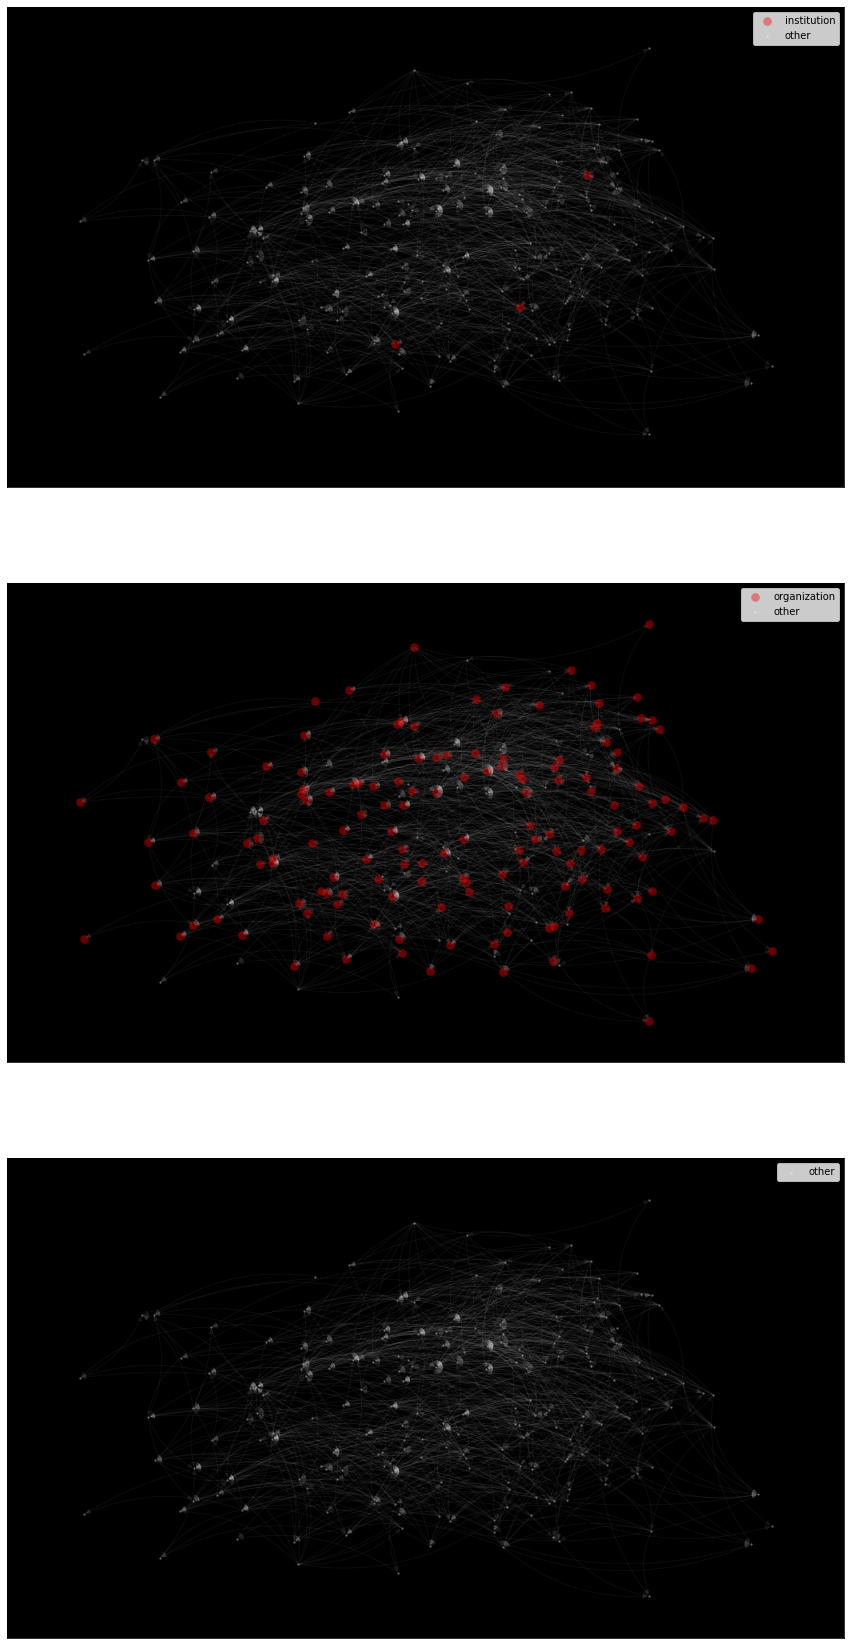

In [29]:
import matplotlib.patches as mpatches

terms = ['institution', 'organization', 'race'] # , "inform", "ecolog", "knowledg"

fig = plt.figure(figsize=(15, 10*len(terms)))
axes = fig.subplots(len(terms), 1)

for (i, term) in enumerate(terms):

    groupby_contains_term = (
        df
        .groupby(
            pl.col('Text').str.split(' ').arr.contains(term)
        )
        .agg([
            pl.col('Doi')
        ])
        .get_column('Doi')
        .to_list()
    )
    
    if len(groupby_contains_term) == 1:
        [with_term, without_term] = [[], groupby_contains_term[0]]
    elif len(groupby_contains_term) == 2:
        [with_term, without_term] = groupby_contains_term
    else:
        raise Exception
    
    nodes_with_term = nx.draw_networkx_nodes(
        G, 
        pos, 
        nodelist=with_term,
        node_size=75,
        node_color='r',
        node_shape='o',
        alpha=0.4,
        ax=axes[i],
        linewidths=0, 
        edgecolors='k', 
        label=f'{term}', 
        margins=None,
    )
    nodes_with_term.set_zorder(1)
    
    nodes_without_term = nx.draw_networkx_nodes(
        G, 
        pos,
        nodelist=without_term,
        node_size=5,
        node_color='w',
        node_shape='o',
        alpha=0.4,
        ax=axes[i],
        linewidths=0, 
        edgecolors='k', 
        label='other', 
        margins=None,
    )
    nodes_without_term.set_zorder(0)

    edge_collection = nx.draw_networkx_edges(
        G,
        pos,
        edgelist=G.edges(),
        width=1.0,
        edge_color='w',
        style='solid',
        alpha=0.05,
        arrowstyle=None,
        arrowsize=10,
        ax=axes[i],
        node_size=5,
        node_shape='o',
        connectionstyle='arc3, rad=0.2',
    )

    for c in edge_collection:
        c.set_zorder(-1)

    axes[i].legend()
    axes[i].set_facecolor('k')
    axes[i].grid(False)

# fig.tight_layout()
plt.show()

In [18]:
from gensim.models import word2vec
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10
num_words = 10
vis = False

id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

lda = LdaModel(corpus, 
            num_topics=num_topics,
            id2word=id2word)

In [21]:
for i in range(num_topics):
    topics = lda.show_topic(i, topn=10)
    print(f'\n{topics}')


[('research', 0.018597068), ('management', 0.016381435), ('process', 0.016051413), ('strategic', 0.014348659), ('system', 0.013233404), ('model', 0.010180864), ('paper', 0.010028814), ('organization', 0.009677318), ('change', 0.00878033), ('information', 0.008163074)]

[('network', 0.07053241), ('capital', 0.03969114), ('human', 0.037868984), ('resource', 0.016144564), ('social', 0.014877099), ('fuzzy', 0.013980016), ('structure', 0.012904672), ('professional', 0.011965684), ('property', 0.010608856), ('theory', 0.0093084)]

[('employee', 0.017326294), ('performance', 0.01573538), ('relationship', 0.014605406), ('study', 0.014406907), ('team', 0.013181208), ('leadership', 0.012158638), ('organizational', 0.012069521), ('effect', 0.011028723), ('behavior', 0.010043301), ('result', 0.008507657)]

[('firm', 0.04523529), ('innovation', 0.038695376), ('performance', 0.02700476), ('capability', 0.019771801), ('orientation', 0.018710272), ('strategic', 0.01353704), ('resource', 0.013535287),

In [22]:
lda.log_perplexity(corpus)

-8.174946889194649

In [38]:
cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
coherence

-2.290450483020662

In [24]:
bow = corpus[0]

doc_topics = lda.get_document_topics(
    bow, 
    minimum_probability=None, 
    minimum_phi_value=None, 
    per_word_topics=False
)

doc_topics

[(0, 0.4013281), (3, 0.030359654), (4, 0.5589347)]

In [30]:

word = 'strategic'

word_id = id2word.token2id[word]

lda.get_term_topics(
    word_id, 
    minimum_probability=None
)

[(0, 0.014318179), (3, 0.013548591), (5, 0.010677219), (6, 0.019671412)]

In [36]:
topic_id = 7
topic_terms = lda.get_topic_terms(
    topic_id, 
    topn=10
)

[(id2word[term_id], p) 
    for (term_id, p) in topic_terms]

[('family', 0.020407388),
 ('education', 0.0146186),
 ('woman', 0.014035868),
 ('state', 0.012368022),
 ('gender', 0.011073341),
 ('country', 0.009481681),
 ('higher', 0.008467209),
 ('inequality', 0.008318326),
 ('job', 0.0071167513),
 ('policy', 0.0070929257)]

In [14]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda, corpus, id2word)

lda_viz

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: Deprec

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.188276 -0.030392       1        1  22.722957
2     -0.130104  0.057381       2        1  17.347771
0     -0.083742 -0.131329       3        1  12.458044
6     -0.023564 -0.089745       4        1  12.333477
9      0.022112  0.145001       5        1   7.321235
8      0.011946  0.087156       6        1   6.740969
4      0.027536  0.091536       7        1   6.740125
5      0.097300 -0.152112       8        1   6.510936
3      0.062453  0.055925       9        1   4.319943
7      0.204339 -0.033421      10        1   3.504543, topic_info=            Term          Freq         Total Category  logprob  loglift
811    knowledge  16164.000000  16164.000000  Default  30.0000  30.0000
508         firm  33487.000000  33487.000000  Default  29.0000  29.0000
56        social  19449.000000  19449.000000  Default  28.0000  28.0000
645      network  17031.000000  17031.000000  Default  27.0000  27.0000
177   innovation  17542.000000  17542.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1069  experience    585.854547   4434.767147  Topic10  -5.3554   1.3270
517       result    606.460351  14981.103294  Topic10  -5.3208   0.1442
508         firm    671.583395  33487.984155  Topic10  -5.2188  -0.5582
34     mechanism    480.383001   4057.772761  Topic10  -5.5539   1.2173
677         role    455.848194  11184.644265  Topic10  -5.6063   0.1510

[843 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
12198      8  0.988330    abatement
1927       5  0.992135  absenteeism
828        1  0.004422   absorptive
828        2  0.002211   absorptive
828        3  0.001106   absorptive
...      ...       ...          ...
1407       7  0.047807    workplace
1407       8  0.002473    workplace
1407       9  0.009891    workplace
1407      10  0.008243    workplace
1364       5  0.991621        youth

[3325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 7, 10, 9, 5, 6, 4, 8])

In [ ]:
# FOR EACH LEVEL, CALCULATE LDA OF NUM COMM

# USE OF LDA COMMUNITY TERMS OVER TIME

